In [1]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, get_continuous_cmap

Load in network labels

In [3]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'scratch')

if not os.path.exists(figdir):
    os.makedirs(figdir)

nii_fname = os.path.join(datadir, 'networks', 'Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')

In [4]:
key = os.path.join(datadir, 'networks', os.path.join(datadir, 'networks', 'Schaefer2018_1000Parcels_7Networks_order.txt'))
key = pd.read_csv(key, sep='\t', header=None, names=['id', 'name', 'x', 'y', 'z', 't']).drop('t', axis=1)
key['study'] = key['name'].apply(lambda x: x.split('_')[0])
key['hemisphere'] = key['name'].apply(lambda x: x.split('_')[1][0])
key['network'] = key['name'].apply(lambda x: x.split('_')[2])
key.drop('name', axis=1, inplace=True)

lookup_table = {
    'Vis': 'Visual',
    'SomMot': 'Somatomotor',
    'DorsAttn': 'Dorsal attention',
    'SalVentAttn': 'Ventral attention',
    'Limbic': 'Limbic',
    'Cont': 'Frontoparietal',
    'Default': 'Default mode'
}

network_colors = {
    'Visual': '#D7DF23',
    'Somatomotor': '#39B54A',
    'Dorsal attention': '#00A79D',
    'Ventral attention': '#27AAE1',
    'Limbic': '#1C75BC',
    'Frontoparietal': '#92278F',
    'Default mode': '#EE2A7B'
}

network_codes = {k: i + 1 for i, k in enumerate(lookup_table.values())}

key['network'] = key['network'].apply(lambda x: lookup_table[x])
key['code'] = key['network'].apply(lambda x: network_codes[x])
key.set_index('id', inplace=True)
key

,x,y,z,study,hemisphere,network,code
id,,,,,,,
1,120,14,127,7Networks,L,Visual,1
2,120,14,128,7Networks,L,Visual,1
3,120,14,129,7Networks,L,Visual,1
4,120,14,130,7Networks,L,Visual,1
5,120,14,131,7Networks,L,Visual,1
...,...,...,...,...,...,...,...
996,208,65,81,7Networks,R,Default mode,7
997,208,65,82,7Networks,R,Default mode,7
998,208,65,83,7Networks,R,Default mode,7


Plot the networks

In [5]:
networks = nlt.Brain_Data(nii_fname)

# convert parcels to network labels
networks.data = np.array([key.loc[i]['code'] if i > 0 else 0 for i in networks.data]).astype(float)

In [11]:
np.unique(networks.data)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [12]:
[v for k, v in network_colors.items()],

(['#D7DF23',
  '#39B54A',
  '#00A79D',
  '#27AAE1',
  '#1C75BC',
  '#92278F',
  '#EE2A7B'],)

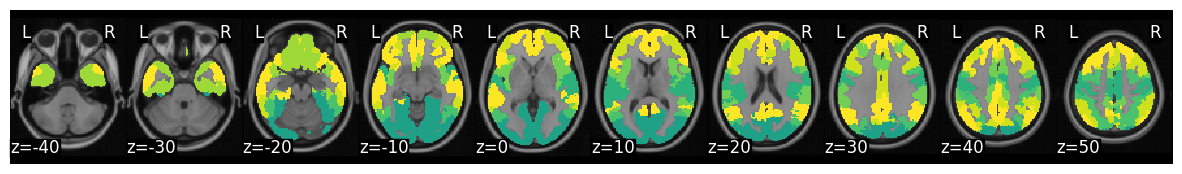

In [16]:
networks.plot(cmap='viridis')

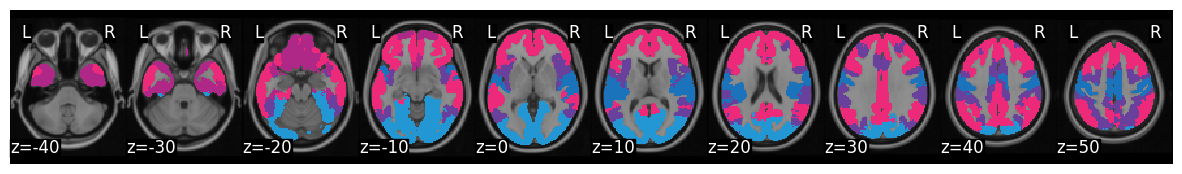

In [10]:
networks.plot(cmap=get_continuous_cmap([v for k, v in network_colors.items()], N=10))

Load in HTFA nodes

In [5]:
url = 'https://www.dropbox.com/s/29a48lv3j5ybcvw/pieman2_htfa.pkl?dl=1'

fname = os.path.join(datadir, 'pieman2_htfa.pkl')
if not os.path.exists(fname):
    with open(fname, 'wb') as f:
        data = requests.get(url).content
        f.write(data)

with open(fname, 'rb') as f:
    data = pickle.load(open(fname, 'rb'))

centers = data['centers']
widths = data['widths']

In [6]:
def rbf(R, center, width):
    return np.exp(-np.sum((R - center) ** 2, axis=1) / width)

Convert between voxels and locations

In [40]:
x = cmu2nii(networks_cmu['Y'], networks_cmu['R'], nii_fname)

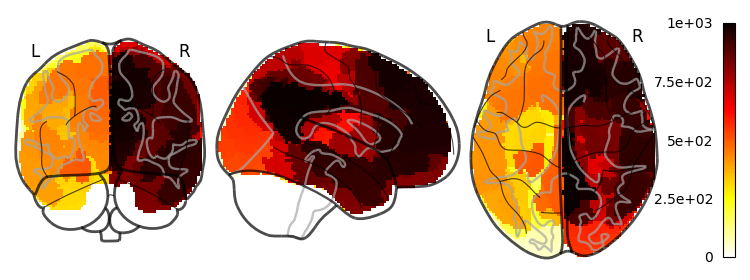

In [41]:
nl.plotting.plot_glass_brain(x, colorbar=True)

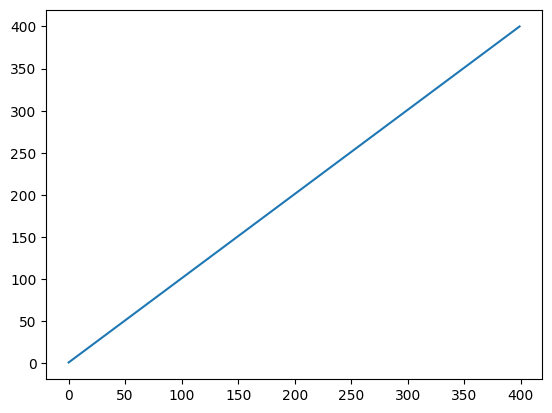

In [15]:
plt.plot(np.unique(networks_cmu['Y']))

^ voxel locations are shifted up when I convert back to nifti format.  I think this is because the sform matrix no longer "matches" the voxel locations matrix.

Options:
  - fix the sform matrix in the YeoEtal2011 networks image so that the voxel locations align with MNI152 space
  - add a correction term to the CMU dictionary (and then fix up the cmu2nii function to accept a dictionary instead of separate Y and R matrices)

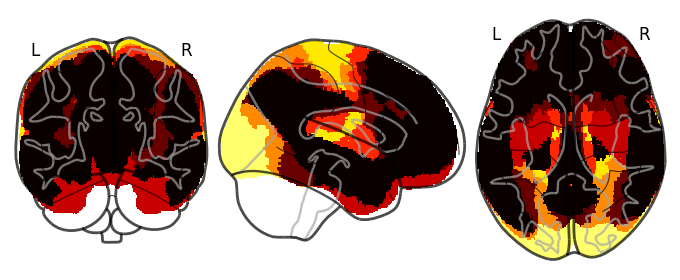

In [18]:
original_nii = nib.load(fname)
nl.plotting.plot_glass_brain(original_nii)

In [19]:
original_nii.get_sform()

array([[  -1.,    0.,    0.,  127.],
       [   0.,    0.,    1., -145.],
       [   0.,   -1.,    0.,  147.],
       [   0.,    0.,    0.,    1.]])

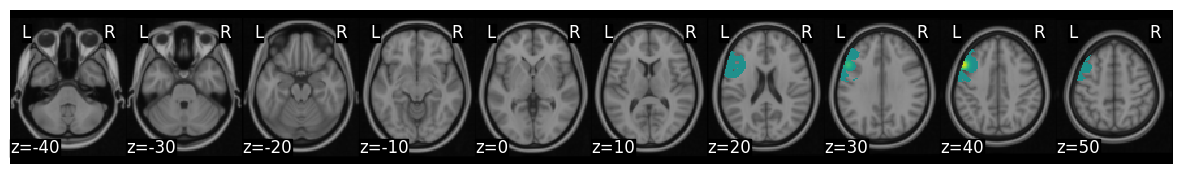

In [249]:
x = cmu2nii(rbf(R, centers[1], widths[1]), R, fname)
xx = nlt.Brain_Data(x)
xx.plot(cmap='viridis')

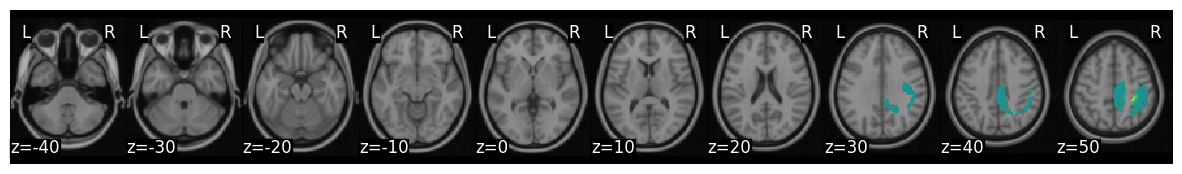

In [250]:
x = cmu2nii(rbf(R, centers[0], widths[0]), R, fname)
xx = nlt.Brain_Data(x)
xx.plot(cmap='viridis')

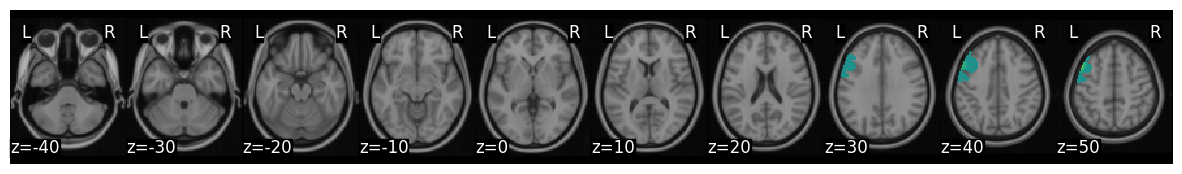

In [251]:
x = cmu2nii(rbf(R, centers[100], widths[100]), R, fname)
xx = nlt.Brain_Data(x)
xx.plot(cmap='viridis')

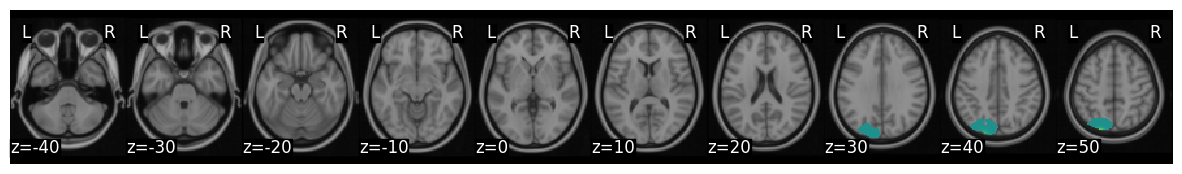

In [252]:
x = cmu2nii(rbf(R, centers[500], widths[500]), R, fname)
xx = nlt.Brain_Data(x)
xx.plot(cmap='viridis')

In [246]:
R.min(axis=0)

array([ -70.11563114, -113.3334789 ,  -54.08578002])

In [243]:
networks_cmu['R'].mean(axis=0)

array([   0.67304996, -271.18792813,  275.923611  ])

In [244]:
mni_cmu['R'].mean(axis=0)

array([  0.55741881, -21.52140703,   9.83783098])

In [238]:
mni_cmu['R'].max(axis=0)

array([72., 72., 80.])

In [230]:
mni_cmu['R'].min(axis=0)

array([ -70., -106.,  -70.])

Note: something strange is going on here-- the y-coordinates and z-coordinates seem shifted (down and up, respectively):

In [236]:
np.max(networks_cmu['R'], axis=0)

array([  71., -183.,  344.])

In [237]:
np.min(networks_cmu['R'], axis=0)

array([ -70., -363.,  212.])

In [194]:
centers.max(axis=0)

array([64.54117043, 65.97245439, 57.85909303])

In [195]:
centers.min(axis=0)

array([-63.88176269, -98.0859451 , -43.26194577])

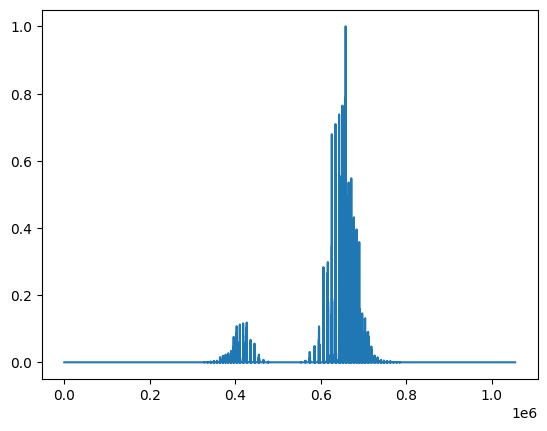

In [190]:
r = rbf(networks_cmu['R'], centers[500, :], 10 * widths[500])  # correction term should not be needed
plt.plot(r)

*All* of the RBFs appear to be in the top/back of the brain due to the weird "shift" issue above:

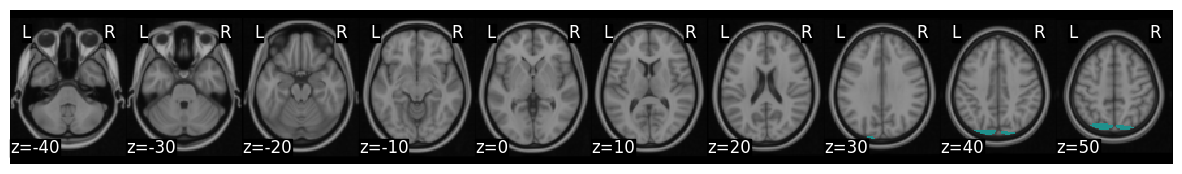

In [191]:
x = cmu2nii(r, networks_cmu['R'], fname)
xx = nlt.Brain_Data(x)
xx.plot(cmap='viridis')

Idea:
  - It looks like the HTFA-derived RBF locations are correct
  - The CMU formatted dataset does *not* look correct.  Maybe the affine transformation matrix in the header is computed incorrectly (translated)?
  - Correcting may be as simple as shifting the mean image to be centered on a template MNI152 image of the same resolution

---

In [3]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
nii_dir = os.path.join(datadir, 'nii')

zipfile_fname = os.path.join(nii_dir, 'Pieman2.zip')
check_file = os.path.join(nii_dir, 'download_complete.txt')
url = 'https://www.dropbox.com/s/0uof8a3t3xxhxcm/pieman_archive.tar.gz?dl=1'
# url = 'https://www.dropbox.com/s/0g5nx37p64eubif/pieman_posterior_K700.mat?dl=1'

if not os.path.exists(check_file):
    if not os.path.exists(nii_dir):
        os.makedirs(nii_dir)
    
    if not os.path.exists(zipfile_fname):
        with open(zipfile_fname, 'wb') as f:
            data = requests.get(url).content
            f.write(data)

        shutil.unpack_archive(zipfile_fname, nii_dir)
        os.remove(zipfile_fname)

        with open(check_file, 'w+') as f:
            f.write(str(dt.now()))

Load data

In [4]:
nii_dir

'/Users/jmanning/pca_paper/data/nii'

In [5]:
nii_files = lsdir(os.path.join(nii_dir, 'new_pieman', '*', 'func', '*.nii'))

In [6]:
fx1 = os.path.join(datadir, 'pieman2.pkl')

if os.path.exists(fx1):
    with open(fx1, 'rb') as f:
        data = pickle.load(f)
else:
    data = {os.path.split(f)[-1][:-len('.nii')]: nlt.data.Brain_Data(data=f) for f in tqdm(nii_files)}

    with open(os.path.join(datadir, 'pieman2.pkl'), 'wb') as f:
        pickle.dump(data, f)

In [7]:
# data2 = {os.path.split(nii_files[i])[-1][:-len('.nii')]: v for i, v in enumerate(data.values())}

In [8]:
# with open(os.path.join(datadir, 'pieman2.pkl'), 'wb') as f:
#         pickle.dump(data2, f)

In [9]:
def subj2cond(x):
    if 'intact' in x:
        return 'intact'
    elif 'paragraph' in x:
        return 'paragraph'
    elif 'word' in x:
        return 'word'
    elif 'rest' in x:
        return 'rest'
    else:
        raise Exception('Unknown condition')

In [10]:
fx2 = os.path.join(datadir, 'pieman2_organized.pkl')

if os.path.exists(fx2):
    with open(fx2, 'rb') as f:
        x = pickle.load(f)
else:
    x = {}
    for k, v in tqdm(data.items()):
        if subj2cond(k) in x:
            x[subj2cond(k)].append(v)
        else:
            x[subj2cond(k)] = [v]

    with open(fx2, 'wb') as f:
        pickle.dump(x, f)

In [11]:
conditions = ['intact', 'paragraph', 'word', 'rest']

# def load_data(fname):
#     htfa = loadmat(fname, simplify_cells=True)['posterior']
#     weights = [pd.DataFrame(htfa['subjects'][i]['image_weights']['mean']) for i in range(len(htfa['subjects']))]
#     data = {}    
#     for c in conditions:
#         data[c] = [w for w, n in zip(weights, htfa['subjects_names']) if c in n]
    
#     return data

# data = load_data(fname)

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [12]:
def group_pca(x, n_components=None):
    pca = PCA(n_components=n_components)
    
    y = pca.fit_transform(x)

    return dw.unstack(pd.DataFrame(index=x.index, data=y))    

In [13]:
scratch_dir = os.path.join(basedir, 'data', 'scratch', 'voxelwise')
if not os.path.exists(scratch_dir):
    os.makedirs(scratch_dir)

reduced_data = {}
max_components = x['intact'][0].data.shape[1]
components = np.linspace(3, max_components, 100).astype(int)

for c in conditions:
    reduced_data[c] = {}
    stacked_data = dw.stack([i.data for i in x[c]])
    for n in tqdm(components):
        fname = os.path.join(scratch_dir, f'pca_{c}_{n}.pkl')        

        if not os.path.exists(fname):
            reduced_data[c][n] = group_pca(stacked_data, n_components=n)

            with open(fname, 'wb') as f:
                pickle.dump(reduced_data[c][n], f)

        with open(fname, 'rb') as f:
            reduced_data[c][n] = pickle.load(f)


  2%|▏         | 2/100 [24:16<19:49:10, 728.07s/it]

: 

: 

In [ ]:
def accuracy(train, test):
    train = np.mean(np.stack(train, axis=2), axis=2)
    test = np.mean(np.stack(test, axis=2), axis=2)
    dists = cdist(train, test, metric='correlation')
    
    labels = np.argmin(dists, axis=1)
    return np.mean([i == d for i, d in enumerate(labels)])

In [ ]:
def cross_validation(data, n_folds=100):
    results = pd.DataFrame(columns=['Fold', 'Number of components', 'Decoding accuracy'])

    n = len(data[3]) // 2
    for i in tqdm(range(n_folds)):
        order = np.random.permutation(len(data[3]))

        for c in range(3, max_components + 1):
            x = pd.DataFrame(columns=['Fold', 'Number of components', 'Decoding accuracy'])
            x.loc[0, 'Fold'] = i
            x.loc[0, 'Number of components'] = c

            train = [data[c][o] for o in order[:n]]
            test = [data[c][o] for o in order[n:]]
            x.loc[0, 'Decoding accuracy'] = (accuracy(train, test) + accuracy(test, train)) / 2

            results = pd.concat([results, x], ignore_index=True)

    return results

In [ ]:
decoding_results = {}
for c in conditions:
    decoding_results[c] = cross_validation(reduced_data[c])
    sns.lineplot(decoding_results[c], x='Number of components', y='Decoding accuracy', label=c.capitalize())

  8%|▊         | 8/100 [1:20:41<15:37:13, 611.23s/it]